In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from collections import deque
from itertools import combinations
import heapq
from collections import defaultdict

# 174 Progression Report

### Preliminary Modeling -- Monte Carlo Poisson Simulations
Using piece-wise homogeneous modeling given data collected 3-week span and averaged for day of week

In [ ]:
# Importing dataset for binge customers per hour, collected over 3 weeks
from google.colab import drive
sheet_url = "https://docs.google.com/spreadsheets/d/1nvWTS0VQe0j76ARMXMNkW_h3Zy_5bPW2/export?format=csv"
binge = pd.read_csv(sheet_url)

In [ ]:
binge

,Week,Day,10:00,11:00,12:00,13:00,14:00,15:00,16:00,17:00,18:00,19:00,20:00
0,1,Mon,18,12,18,25,24,28,36,37,40,37,32
1,1,Tues,13,17,14,18,24,31,28,36,29,43,44
2,1,Wed,14,12,22,23,27,28,25,39,23,34,41
3,1,Thu,17,22,23,17,19,27,27,30,44,43,39
4,1,Fri,14,15,24,21,26,19,27,24,36,39,56
5,1,Sat,23,22,36,29,30,35,31,33,41,54,46
6,1,Sun,20,20,20,37,33,41,37,47,59,39,43
7,2,Mon,16,13,20,16,18,31,25,36,27,49,36
8,2,Tues,17,12,32,31,24,33,25,34,37,35,43
9,2,Wed,14,14,25,13,19,24,39,29,27,25,43


In [ ]:
#computing average over three weeks to compute lambdas for the dataset
binge_average = binge.groupby(['Day']).mean().drop(columns=['Week'])
week_order = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
binge_average = binge_average.reindex(week_order)
binge_average

,10:00,11:00,12:00,13:00,14:00,15:00,16:00,17:00,18:00,19:00,20:00
Day,,,,,,,,,,,
Mon,16.000000,15.333333,17.333333,21.666667,22.666667,30.666667,30.000000,34.000000,35.666667,39.666667,37.000000
Tue,13.000000,16.000000,22.333333,26.666667,25.333333,26.000000,25.333333,35.666667,36.000000,40.000000,40.666667
Wed,11.666667,15.333333,20.000000,21.000000,24.000000,30.333333,31.666667,31.333333,27.666667,29.333333,40.000000
Thu,14.666667,16.000000,19.333333,21.333333,19.333333,28.000000,32.000000,36.000000,41.333333,40.666667,39.000000
Fri,18.666667,16.333333,19.333333,21.666667,20.333333,23.000000,27.333333,35.333333,32.000000,37.666667,49.000000
Sat,22.000000,23.000000,27.000000,24.333333,31.000000,36.666667,42.333333,39.666667,39.333333,49.333333,50.333333
Sun,18.333333,23.666667,27.666667,31.000000,32.666667,38.333333,37.333333,48.333333,52.666667,45.666667,53.666667


In [ ]:
### ADJUSTING BASED ON EMPLOYEE DRINK MAKING TIMES

In [ ]:
# Core NHPP-by-hour arrival generation (exact for stepwise λ)

def simulate_arrivals_one_hour(lam_h, hour_len=3600.0, rng=None):
    """
    Generate arrival times for one hour with homogeneous Poisson rate lam_h (arrivals/hour).
    Returns sorted arrival times (seconds from hour start).
    """
    rng = np.random.default_rng(rng)
    n = rng.poisson(lam=lam_h)  # hour length = 1, so mean = lam_h * 1
    if n == 0:
        return np.empty(0, dtype=float)
    u = rng.random(n)
    return np.sort(u * hour_len)

# Multi-server queue simulator with heterogeneous employees
def simulate_hour_queue(arrivals_sec, employees_mus_per_sec, rng=None):
    """
    Simulate one hour (plus any spillover until all in service finish).
    arrivals_sec: np.array of arrival times within the hour [0, 3600)
    employees_mus_per_sec: list of service rates per employee in 1/seconds (μ_i).
    Returns: dict with mean_wait (s), util_by_emp, num_in_system_at_hour_end, total_service_time_by_emp.
    """
    rng = np.random.default_rng(rng)
    HOUR_END = 3600.0

    if len(employees_mus_per_sec) == 0:
        # No staff: everyone waits until infinite; we’ll handle by returning inf
        return {
            "mean_wait": float('inf'),
            "num_in_system_at_hour_end": len(arrivals_sec),
            "util_by_emp": np.zeros(0),
            "total_service_time_by_emp": np.zeros(0),
        }

    # Min-heap of (next_free_time, emp_idx)
    # All servers free at t=0 initially
    free_heap = [(0.0, i) for i in range(len(employees_mus_per_sec))]
    heapq.heapify(free_heap)

    waits = []
    # Track busy time to compute utilization
    total_service_time = np.zeros(len(employees_mus_per_sec))

    for t in arrivals_sec:
        next_free_time, emp = heapq.heappop(free_heap)
        start = max(t, next_free_time)
        mu_i = employees_mus_per_sec[emp]
        service = rng.exponential(scale=1.0/mu_i)  # Exp with mean 1/μ_i
        depart = start + service
        waits.append(start - t)
        total_service_time[emp] += service
        heapq.heappush(free_heap, (depart, emp))

    # Customers still in system at HOUR_END
    num_in_system_at_hour_end = sum(1 for ft, _ in free_heap if ft > HOUR_END)

    # Utilization per employee over the hour (truncate to 3600 if desired)
    util = np.minimum(total_service_time / HOUR_END, 1.0)

    return {
        "mean_wait": float(np.mean(waits)) if waits else 0.0,
        "num_in_system_at_hour_end": int(num_in_system_at_hour_end),
        "util_by_emp": util,
        "total_service_time_by_emp": total_service_time,
    }

In [ ]:
# Evaluate staffing options via simulation
def evaluate_staffing_for_hour(
    lam_h,
    employees_speeds_drinks_per_min,  # dict: name -> drinks/min
    min_staff=3,
    max_staff=4,
    replications=200,
    current_daily_hours=None,
    current_weekly_hours=None,
    max_daily_hours=None,
    max_weekly_hours=None,
    rng=None
):
    """
    For a given hour arrival rate lam_h, simulate all combos of employees with size in [min_staff, max_staff].
    Pick the combo minimizing mean wait (seconds). Returns best_choice dict.
    """
    rng = np.random.default_rng(rng)

    # Precompute arrivals for each replication to keep arrivals consistent across combos (fair comparison)
    arrivals_per_rep = [simulate_arrivals_one_hour(lam_h, rng=rng) for _ in range(replications)]

    all_names = list(employees_speeds_drinks_per_min.keys())
    all_speeds = np.array([employees_speeds_drinks_per_min[n] for n in all_names], dtype=float) # drinks/min
    all_mus_per_sec = all_speeds / 60.0 # services per second

    eligible_employee_info = []
    for i, name in enumerate(all_names):
        can_work_daily = (current_daily_hours is None) or (current_daily_hours[name] < max_daily_hours)
        can_work_weekly = (current_weekly_hours is None) or (current_weekly_hours[name] < max_weekly_hours)
        if can_work_daily and can_work_weekly:
            eligible_employee_info.append((name, all_mus_per_sec[i]))

    eligible_names = [info[0] for info in eligible_employee_info]
    eligible_mus_per_sec = [info[1] for info in eligible_employee_info]

    # Adjust min_staff and max_staff based on eligible employees
    num_eligible = len(eligible_names)
    current_min_staff = max(0, min(min_staff, num_eligible))
    current_max_staff = min(max_staff, num_eligible)

    best = {
        "employees": [], # Changed to empty list for better default
        "mean_wait_sec": float('inf'),
        "utilization_by_emp": None,
        "num_in_system_at_hour_end": None
    }

    # Only proceed if there are enough eligible employees to meet at least min_staff
    if current_min_staff > 0 and num_eligible > 0:
        for k in range(current_min_staff, current_max_staff + 1):
            for idxs in combinations(range(num_eligible), k):
                # Build μ list for chosen employees
                selected_names = [eligible_names[i] for i in idxs]
                selected_mus_sec = [eligible_mus_per_sec[i] for i in idxs]

                # Run simulation across replications
                waits = []
                end_in_system = []
                utils_accum = np.zeros(k)

                for r in range(replications):
                    res = simulate_hour_queue(arrivals_per_rep[r], selected_mus_sec, rng=rng)
                    waits.append(res["mean_wait"])
                    end_in_system.append(res["num_in_system_at_hour_end"])
                    # Align utilization vector order with selected employees
                    utils_accum += res["util_by_emp"]

                mean_wait = float(np.mean(waits)) if waits else float('inf')
                mean_end_in_system = float(np.mean(end_in_system))
                mean_utils = utils_accum / replications

                if mean_wait < best["mean_wait_sec"]:
                    best = {
                        "employees": selected_names,
                        "mean_wait_sec": mean_wait,
                        "utilization_by_emp": dict(zip(selected_names, mean_utils)),
                        "num_in_system_at_hour_end": mean_end_in_system
                    }
    # If no valid combination could be found (e.g. not enough eligible staff), best.employees remains empty
    if not best["employees"] and current_min_staff > 0:
        # This can happen if there are eligible employees but not enough to meet min_staff
        pass


    return best

# Planning across a full day and full week
def plan_week_schedule(
    lambda_df, # pandas DataFrame: index=days, columns=hours, values=λ
    employees_speeds_drinks_per_min, # dict name -> drinks/min
    min_staff=3,
    max_staff=4,
    replications=200,
    max_daily_hours_per_employee=8,
    max_weekly_hours_per_employee=40,
    rng=None
):
    """
    For each day/hour (row/column in lambda_df),
    choose staffing combo (3–4 employees) minimizing mean wait.
    Returns nested results {day: [{hour,...}, ...]} and a flattened summary DataFrame.
    """
    rng = np.random.default_rng(rng)

    results = {}
    records = []

    # Initialize weekly hours worked for each employee
    weekly_hours_worked = {name: 0 for name in employees_speeds_drinks_per_min.keys()}

    for day in lambda_df.index:
        # Initialize daily hours worked for each employee at the start of each day
        daily_hours_worked = {name: 0 for name in employees_speeds_drinks_per_min.keys()}

        lam_vec = lambda_df.loc[day].values.astype(float)
        day_out = []
        for hour, lam_h in zip(lambda_df.columns, lam_vec):
            best = evaluate_staffing_for_hour(
                lam_h=lam_h,
                employees_speeds_drinks_per_min=employees_speeds_drinks_per_min,
                min_staff=min_staff,
                max_staff=max_staff,
                replications=replications,
                current_daily_hours=daily_hours_worked,
                current_weekly_hours=weekly_hours_worked,
                max_daily_hours=max_daily_hours_per_employee,
                max_weekly_hours=max_weekly_hours_per_employee,
                rng=rng
            )

            # Update daily and weekly hours for chosen employees
            for emp_name in best["employees"]:
                daily_hours_worked[emp_name] += 1
                weekly_hours_worked[emp_name] += 1

            chosen_employees_str = ", ".join(best["employees"]) if best["employees"] else "No Staff Found"

            row = {
                "Day": day,
                "Hour": hour,
                "Lambda_per_hour": lam_h,
                "Expected_customers": lam_h,
                "Chosen_employees": chosen_employees_str,
                "Mean_wait_min": best["mean_wait_sec"]/60,
                "Avg_in_system_at_hour_end": best["num_in_system_at_hour_end"]
            }
            records.append(row)
            day_out.append(row)
        results[day] = day_out

    schedule_df = pd.DataFrame(records)
    return results, schedule_df, weekly_hours_worked

if __name__ == "__main__":
    lambdas_by_day = binge_average

    employees = {
        "Ava": 1.2, # drinks/min  => μ = 1.2/60 per second
        "Ben": 1.0,
        "Cara": 1.4,
        "Dee": 0.9,
        "Eli": 1.1,
        "Sean":0.8,
        "Lily":1.2,
        "Vivian":1.3,
        "Maya":1.1,
        "Paul":1.0,
    }

    # Choose 2–4 employees each hour to minimize average wait
    schedule, schedule_df_output, final_weekly_hours = plan_week_schedule(
        lambdas_by_day,
        employees_speeds_drinks_per_min=employees,
        min_staff=2,
        max_staff=4,
        replications=250,
        max_daily_hours_per_employee=6,
        max_weekly_hours_per_employee=40,
        rng=42
    )

    rows = []
    for slot in schedule["Fri"]:
        rows.append({
            "hour": slot["Hour"],
            "lambda": slot["Lambda_per_hour"],
            "expected_customers": slot["Expected_customers"],
            "chosen_employees": slot["Chosen_employees"],
        })
    df = pd.DataFrame(rows)
    print(df)
    print("\nFinal weekly hours worked:")
    print(final_weekly_hours)


     hour     lambda  expected_customers         chosen_employees
0   10:00  18.666667           18.666667      Ava, Ben, Cara, Eli
1   11:00  16.333333           16.333333      Ava, Ben, Cara, Eli
2   12:00  19.333333           19.333333     Ava, Ben, Cara, Sean
3   13:00  21.666667           21.666667   Ava, Ben, Lily, Vivian
4   14:00  20.333333           20.333333     Ava, Ben, Cara, Sean
5   15:00  23.000000           23.000000   Ava, Ben, Cara, Vivian
6   16:00  27.333333           27.333333  Cara, Eli, Sean, Vivian
7   17:00  35.333333           35.333333   Dee, Eli, Vivian, Maya
8   18:00  32.000000           32.000000   Dee, Eli, Vivian, Paul
9   19:00  37.666667           37.666667  Eli, Lily, Vivian, Maya
10  20:00  49.000000           49.000000    Dee, Lily, Maya, Paul

Final weekly hours worked:
{'Ava': 40, 'Ben': 36, 'Cara': 40, 'Dee': 18, 'Eli': 33, 'Sean': 15, 'Lily': 35, 'Vivian': 38, 'Maya': 27, 'Paul': 21}


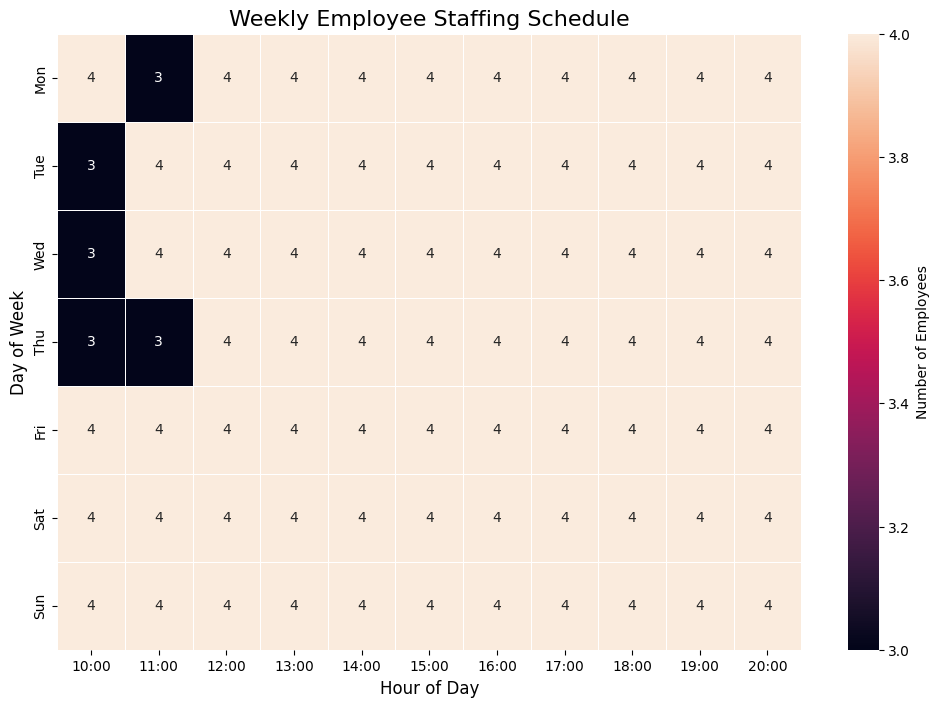

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'Chosen_employees' into a numerical count of employees
schedule_df_output['Num_Employees'] = schedule_df_output['Chosen_employees'].apply(
    lambda x: len(x.split(', ')) if x != 'No Staff Found' else 0
)

# Pivot the DataFrame
week_order = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
pivoted_schedule = schedule_df_output.pivot_table(
    index='Day',
    columns='Hour',
    values='Num_Employees'
).reindex(week_order)

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    pivoted_schedule,
    annot=True,
    fmt="g",
    linewidths=.5,
    cbar_kws={'label': 'Number of Employees'}
)

plt.title('Weekly Employee Staffing Schedule', fontsize=16)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Day of Week', fontsize=12)
plt.show()